# Apply Spectral Differencing to DESI Spectra

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

In [16]:
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desitarget.cmx.cmx_targetmask import cmx_mask

# from desitrip.preproc import rebin_flux, rescale_flux

from astropy.io import fits
from astropy.table import Table, vstack, hstack

from glob import glob
from datetime import date

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import fitsio

from tensorflow import keras

import numpy.ma as ma

import copy

from matplotlib.backends.backend_pdf import PdfPages
mpl.rc('font', size=14)

In [17]:
### properties of file system and strings in file names

In [31]:
redux='/global/project/projectdirs/desi/spectro/redux/'
filts = ['b','r','z']
panels = np.arange(10).astype('str')

### Utilities

In [32]:
def fitsfile(tile, date, panel, subdir='andes',trunk='coadd'):
    name  = os.path.join(redux,subdir,'tiles',tile, date, '{}-{}-{}-{}.fits'.format(trunk,panel,tile,date))
    exists = os.path.exists(name)
    if exists:
        return os.path.join(redux,subdir,'tiles',tile, date, '{}-{}-{}-{}.fits'.format(trunk,panel,tile,date))
    else:
        return None

In [33]:
def tiledateToExposures(tile, date, subdir='andes'):

    dirname = os.path.join(redux,subdir,'tiles',tile,date)
    if not os.path.isdir(dirname):
        print('{} does not exist.'.format(dirname))    
    cafiles =  glob(os.path.join(dirname,'cframe-??-*.fits'))
    exposures=[]

    for cafile in cafiles:
        index0 = cafile.find('cframe-')
        index1 = cafile.find('.fits',index0+10)
        exposures.append(cafile[index0+10:index1])

    exposures = np.unique(exposures)
    return exposures

# tile = "70006"
# date = "20200305"    
# tn=tiledateToExposures(tile,date)

In [34]:
def dateToTiles(date, subdir='andes'):

    dirname = os.path.join(redux,subdir,'tiles')
    if not os.path.isdir(dirname):
        print('{} does not exist.'.format(dirname))    
    cafiles =  glob(dirname+'/*/'+date)

    tiles=[]

    for cafile in cafiles:
        index0 = cafile.find('/'+date)
        index1 = cafile.rfind('/',0,index0-1)
        tiles.append(cafile[index1+1:index0])

    return tiles

# date = "20200305"    
# print(dateToTiles(date))

In [35]:
def tileToDates(tile, subdir='andes'):

    dirname = os.path.join(redux,subdir,'tiles',tile)
    if not os.path.isdir(dirname):
        print('{} does not exist.'.format(dirname))  
        
    dates = [f.path for f in os.scandir(dirname) if f.is_dir()]

    for i in range(len(dates)):
        dates[i] = dates[i][dates[i].rfind('/')+1:]

    return dates

# tile = "70006"  
# print(tileToDates(tile))

In [36]:
class PairCoadds:

    def __init__(self, tile, subdir='andes'):
        self.tile = tile
        self.subdir=subdir
        self.dates = tileToDates(tile,subdir=subdir)
        if (len(self.dates) <=1):
            self.a=1
        else:
            self.a = 0
        self.b = 1
        self.panel = 0
        
    def __iter__(self):
        if (len(self.dates) <=1):
            self.a=1
        else:
            self.a = 0
        self.b = 1
        self.panel = 0
        return self
    
    def __next_index__(self):
        if self.panel+1 < len(panels):
            self.panel +=1
        else:
            self.panel=0
            if self.b +1 < len(self.dates):
                self.b+=1
            else:
                self.a+=1
                self.b = self.a+1

    def __next__(self):
           
        while self.a+1 < len(self.dates):
            df0 = fitsfile(tile,self.dates[self.a],panels[self.panel])
            df1 = fitsfile(tile,self.dates[self.b],panels[self.panel])

            if (df0 is not None and df1 is not None):
                ans =  (df0,df1)
                self.__next_index__()
                break
        
            self.__next_index__()

        else:
            raise StopIteration
        
        return ans

# tile = "70006"
# for c in PairCoadds(tile):
#     print (c)

In [37]:
class TileDate:
    
    def __init__(self, tile, date, subdir='andes'):
        dirname = os.path.join(redux,subdir,'tiles',tile,date)
        if not os.path.isdir(dirname):
            print('{} does not exist.'.format(dirname))    
        self.tile = tile
        self.date = date
        self.subdir = subdir
        cafiles =  glob(os.path.join(dirname,'cframe-??-*.fits'))
        exposures=[]

        for cafile in cafiles:
            index0 = cafile.find('cframe-')
            index1 = cafile.find('.fits',index0+10)
            exposures.append(cafile[index0+10:index1])

        exposures = np.unique(exposures)
        print(exposures)
        
    def __iter__(self):
        self.a = 1
        return self

    def __next__(self):
        x = self.a
        self.a += 1
        return x
    
tile = "70006"
date = "20200305"

tn=TileDate(tile,date)

['00053521' '00053524']


## Calculate the difference between two Spectra

In [38]:
def difference(s0, s1):
    diff = dict()
    ivar = dict()
    mask = dict()
    for dindex in s1.bands:

        diff[dindex] = ma.array(data=s1.flux[dindex],mask=s1.mask[dindex])
        diff[dindex] = diff[dindex] - ma.array(data=s0.flux[dindex],mask=s0.mask[dindex])

        ivar0 = ma.array(data=s0.ivar[dindex],mask=s0.mask[dindex])
        ivar1 = ma.array(data=s1.ivar[dindex],mask=s1.mask[dindex])
        ivar[dindex] = 1/(1/ivar0 + 1/ivar1)
        mask[dindex] = diff[dindex].mask.astype('int')
        
    return Spectra(bands=s1.bands.copy(), wave=dict(s1.wave), flux=diff,ivar=ivar,mask=mask)

## Logic

### CV selection (static class)

In [39]:
class CVLogic:
    target_wave = (6562.79, 4861.35, 4340.472, 4101.734, 3970.075)
    R=1000.
    ston_cut=5.

    @staticmethod
    def filter(diff):
        signal=0.
        var=0.
        for dindex in diff.bands:
            for wa in CVLogic.target_wave:
                wmin = wa * np.exp(-1/CVLogic.R)
                wmax = wa * np.exp(1/CVLogic.R)
                w = np.logical_and(diff.wave[dindex] >= wmin, diff.wave[dindex] < wmax)
                signal +=  diff.flux[dindex][:,w].sum(axis=1)
                var += (diff.ivar[dindex][:,w]).sum(axis=1)
        return (np.abs(signal)/np.sqrt(var) >= CVLogic.ston_cut)

### Single element selection (static class)

In [40]:
class SingleElementLogic:
    ston_cut=7.
    
    @staticmethod
    def filter(diff):    
        for i, dindex in enumerate(diff.bands):
            if i==0:
                ans = np.any(np.abs(diff.flux[dindex])*np.sqrt(diff.ivar[dindex]) > SingleElementLogic.ston_cut, axis=1)
            else:
                ans = np.logical_or(ans,np.any(np.abs(diff.flux[dindex])*np.sqrt(diff.ivar[dindex]) > SingleElementLogic.ston_cut, axis=1))
        return ans

## Save to PDF or not

In [41]:
makepdf=False
if makepdf:
    pdf = PdfPages('{}.pdf'.format(tile_id))

In [42]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError( "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(window_len/2-1):-int(window_len/2)-1]

29


NameError: name 'wefwe' is not defined

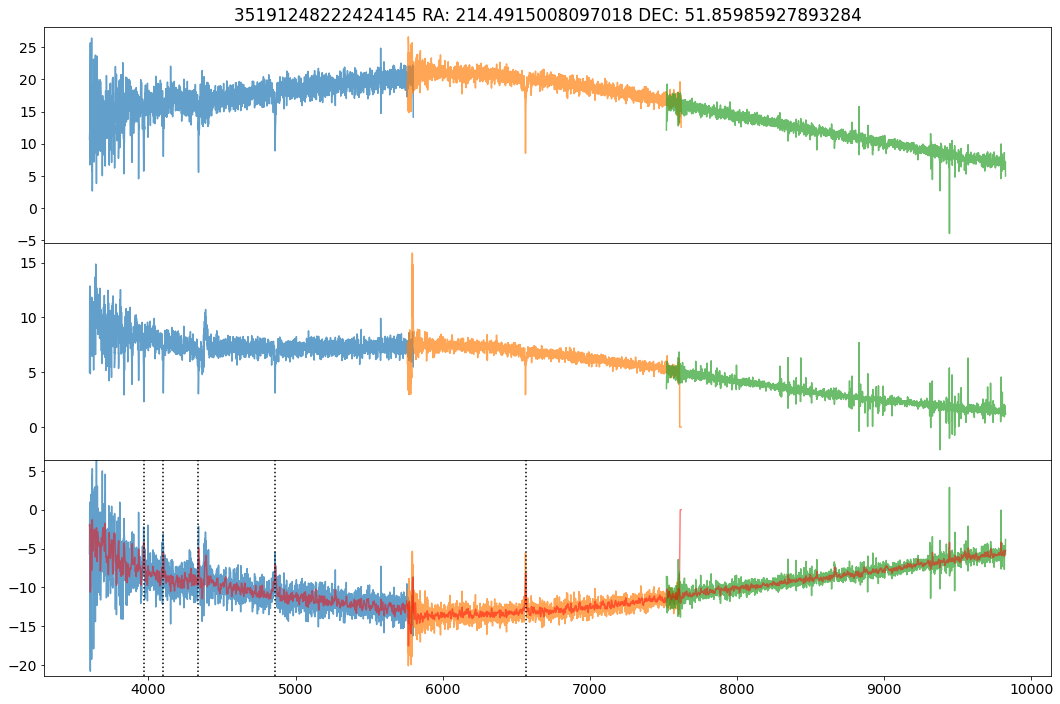

In [43]:
tile = "70006"
iterator = PairCoadds(tile)
logic = SingleElementLogic
for (datafile0,datafile1) in PairCoadds(tile):
    # which of these are real targets
    fibermap = Table.read(datafile0, 'FIBERMAP')
    isTGT = fibermap['OBJTYPE'] == 'TGT'

    pspectra0 = read_spectra(datafile0)
    pspectra1 = read_spectra(datafile1)
    
    diff = difference(pspectra0,pspectra1)
    significant = logic.filter(diff)

    triggered = np.logical_and.reduce((significant, isTGT))

    # plot triggered objects
    print(triggered.sum())
    wheretriggered = np.where(triggered)[0]
    for sig in np.nditer(wheretriggered):
        lims = []
        fig, axes = plt.subplots(3,1, figsize=(15,10), sharex=True, sharey=False, gridspec_kw={'wspace':0, 'hspace':0})
        for dindex in pspectra0.bands:
            wave = pspectra0.wave[dindex]
            diff = ma.array(data=pspectra1.flux[dindex],mask=pspectra1.mask[dindex])
            diff = diff - ma.array(data=pspectra0.flux[dindex],mask=pspectra0.mask[dindex])                        
            axes[0].plot(wave,pspectra0.flux[dindex][sig,:],alpha=0.7)
            axes[1].plot(wave,pspectra1.flux[dindex][sig,:],alpha=0.7)
            axes[2].plot(wave,diff[sig,:],alpha=0.7)
            axes[2].plot(wave,smooth(diff[sig,:]),color='red',alpha=0.5)
#                        axes[2].plot(wave,diff[whereSky[0][0],:],color='yellow',alpha=0.5)
            lims.append(np.percentile(diff[sig,:],(0.01,99.99)))
        lims=np.array(lims)
        lims = [lims.min()*1.05,lims.max()*1.05]
        axes[2].set_ylim(lims)
        for wav in CVLogic.target_wave:
            axes[2].axvline(wav,ls=':',color='black')
        axes[0].set_title("{} RA: {} DEC: {}".format(fibermap['TARGETID'].data[sig],fibermap['TARGET_RA'].data[sig],fibermap['TARGET_DEC'].data[sig]))
        fig.tight_layout()
        fig.show()
        wefwe
    if makepdf:
        pdf.savefig()
        fig.clf()
    else:
        plt.show()


if makepdf:
    pdf.close()
    print (c)
    

In [69]:
# get wedges available for each date
wedges=[]
for obsdate in obsdates:
    cafiles = sorted(glob('{}/{}/coadd*.fits'.format(prefix_in,obsdate)))
    pas = []
    for cafile in cafiles:
        index0 = cafile.find('coadd-')
        index1 = cafile.find('-',index0+6)
        pas.append(cafile[index0+6:index1])
    wedges.append(pas)
    
wedges

[['0', '1', '3', '5', '6', '7', '8', '9'],
 ['0', '3', '6', '7', '8', '9'],
 ['0', '3', '6', '7', '9']]

# From here on out are remnants of Segev's original code, which I keep in case needed later

In [ ]:
# List zbest and coadd files.
# Data are stored by petal ID.
zbfiles = sorted(glob('{}/zbest*.fits'.format(prefix_in)))
cafiles = sorted(glob('{}/coadd*.fits'.format(prefix_in)))

In [ ]:
# zbest files from redrock.
zbfiles

In [ ]:
# Co-added spectra from multiple exposures + the three spectrograph arms.
cafiles

## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [ ]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
# tfmodel = '/'.join([os.environ['HOME'], 'desi/timedomain/desitrip/docs/nb', '6label_cnn_restframe'])
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [104]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [105]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None

In [106]:
for cafile, zbfile in zip(cafiles, zbfiles):
    # Access data per petal.
    zbest = Table.read(zbfile, 'ZBEST')
    fibermap = Table.read(zbfile, 'FIBERMAP')
    pspectra = read_spectra(cafile)

    # Apply standard event selection.
    isTGT = fibermap['OBJTYPE'] == 'TGT'
    isGAL = zbest['SPECTYPE'] == 'GALAXY'
    isBGS = fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = isTGT & isGAL & isBGS

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[select]
        allfmap = fibermap[select]
        allwave = pspectra.wave['brz']
        allflux = pspectra.flux['brz'][select]
        allivar = pspectra.ivar['brz'][select]
        allmask = pspectra.mask['brz'][select]
        allres  = pspectra.resolution_data['brz'][select]
    else:
        allzbest = vstack([allzbest, zbest[select]])
        allfmap = vstack([allfmap, fibermap[select]])
        allflux = np.vstack([allflux, pspectra.flux['brz'][select]])
        allivar = np.vstack([allivar, pspectra.ivar['brz'][select]])
        allmask = np.vstack([allmask, pspectra.mask['brz'][select]])
        allres  = np.vstack([allres, pspectra.resolution_data['brz'][select]])

In [107]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [108]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [115]:
pred[:10]

array([[1.81230810e-02, 9.35710967e-03, 2.89104193e-01, 4.37462819e-04,
        3.30427685e-03, 5.06455362e-01, 8.63643512e-02, 3.32549922e-02,
        5.35991192e-02],
       [1.51045918e-01, 5.08262264e-03, 2.12446898e-01, 8.30744021e-03,
        1.63734451e-01, 1.65949706e-02, 3.61227104e-03, 3.61317769e-02,
        4.03043717e-01],
       [1.17874183e-01, 1.36392040e-03, 1.49358645e-01, 8.81225616e-03,
        3.95394042e-02, 2.68493342e-04, 1.32946868e-03, 4.43459526e-02,
        6.37107670e-01],
       [1.27340807e-03, 3.23002256e-04, 1.48098473e-03, 6.54825926e-05,
        3.17751504e-02, 2.92203110e-03, 8.16936154e-05, 2.07877136e-04,
        9.61870372e-01],
       [8.46084580e-02, 3.17124993e-01, 4.03926492e-01, 1.87212061e-02,
        2.18924489e-02, 1.05727799e-02, 7.36096699e-04, 2.66064256e-02,
        1.15811065e-01],
       [2.28880271e-01, 2.50207745e-02, 4.34927374e-01, 2.92403647e-03,
        7.67460698e-03, 2.26744130e-01, 1.42376330e-02, 4.17456403e-02,
        1.7

In [116]:
pred.shape

(2555, 9)

In [117]:
ymax = np.max(pred, axis=1)

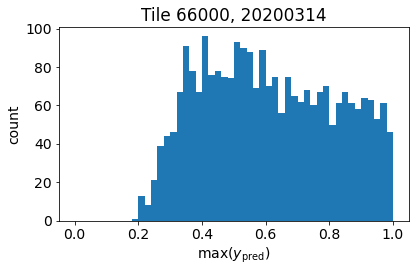

In [118]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count',
       title='Tile {}, {}'.format(tile_id, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [124]:
idx = np.argwhere(ymax > 0.99)
labels = np.argmax(pred, axis=1)

In [125]:
idx.shape

(19, 1)

In [126]:
# Randomly select 16 of the spectra and plot them.
selection = sorted(np.random.choice(idx.flatten(), size=16, replace=False))

0.12796538985535383
0.013748912227626843
0.25506857583278325
0.36468320816075467
0.36045455586167113
0.15534892936220615
0.4034336065301028
0.21009290012131826
0.25758541352635766
0.7685567962770793
0.31840248253822523
0.11039665926310184
0.1999158021840981
0.1789370868111838
0.4210215355237692
0.2563778296487622


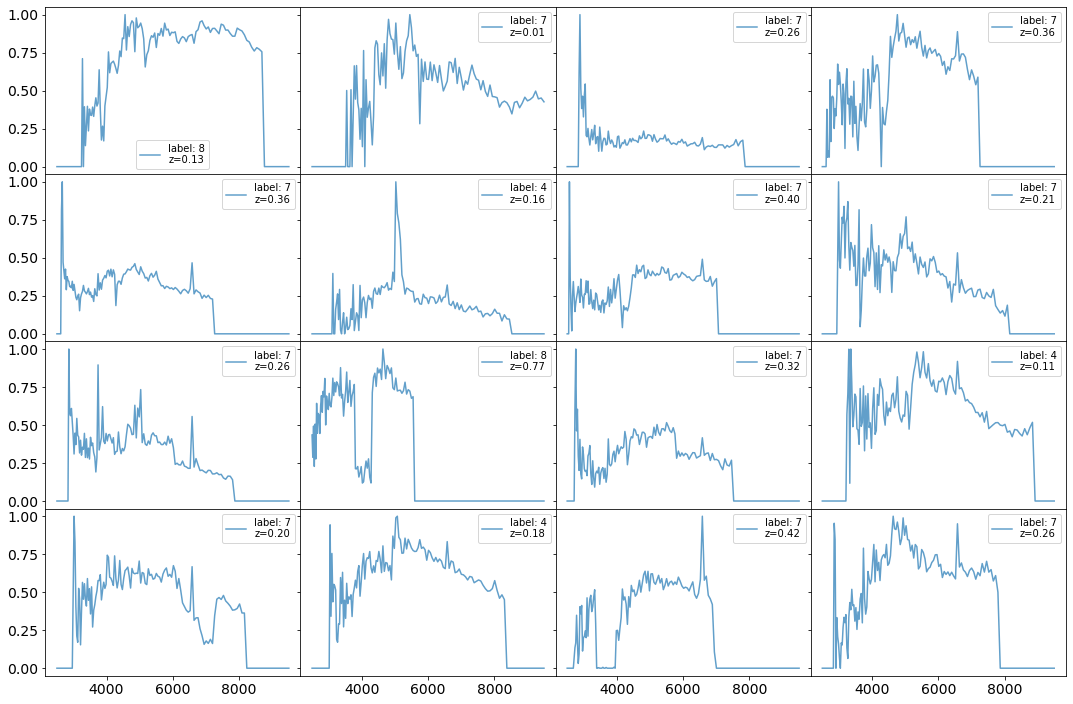

In [138]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(rewave, rsflux[j], alpha=0.7, label='label: {}\nz={:.2f}'.format(labels[j], allzbest[j]['Z']))
    print(allzbest[j]['Z'])
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();

In [139]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

0.12796538985535383
0.013748912227626843
0.25506857583278325
0.36468320816075467
0.36045455586167113
0.15534892936220615
0.4034336065301028
0.21009290012131826
0.25758541352635766
0.7685567962770793
0.31840248253822523
0.11039665926310184
0.1999158021840981
0.1789370868111838
0.4210215355237692
0.2563778296487622


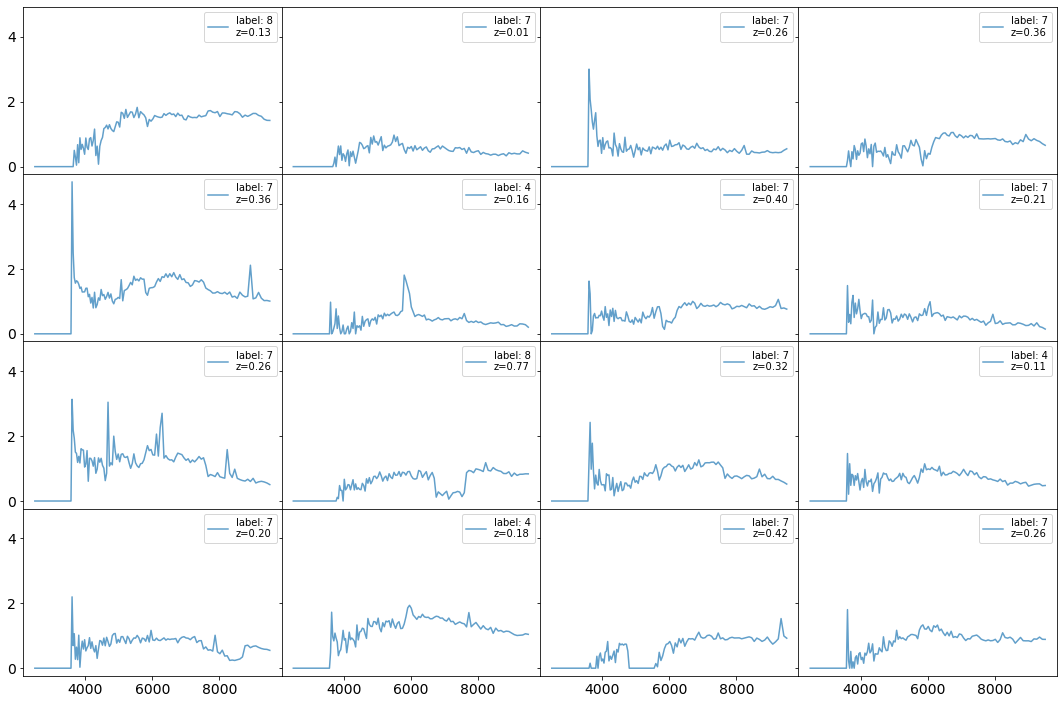

In [140]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j], alpha=0.7, label='label: {}\nz={:.2f}'.format(labels[j], allzbest[j]['Z']))
    print(allzbest[j]['Z'])
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();

In [141]:
idx

array([[  23],
       [  99],
       [ 515],
       [ 530],
       [ 609],
       [ 642],
       [ 723],
       [ 730],
       [ 862],
       [1039],
       [1040],
       [1167],
       [1182],
       [1305],
       [1346],
       [1579],
       [2411],
       [2426],
       [2476]])

In [144]:
allfmap[609]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35190944420597419,2,81,2081,1274,0,216.23055804330218,34.622934471197325,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,155.12483,-92.11976,0,10000,0.7190027677838118,65535,100,8001,518390,2161p345,3755,REX,460931920000.0,495543980000.0,0.011219671,3.379395,6.937374,10.423504,331.99625,145.56847,98.54945,0.96733296,0.97787595,0.98756385,0.0,0.0,0.0,0.008477836,0.007234626,0.009298617,0.996539,0.9974114,0.9998964,3,3,3,595.3819,251.59889,169.10493,423.44073,167.86615,81.45692,11.123857,8.197101,50.670284,453.0044,3.9210799,0.756751,0.0018595384,2.2319427e-05,0.9981004,0.998833,0.999751,0.99990594,0,0,0,2.249883,4.618661,6.9396043,2.249883,4.618661,6.9396043,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27826062,0.0,0.0,27611.193,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,256,2100,1,10515,0.0,0.0,0.0,0.0,0,0,0,3,155.061,-92.078,0.00125,0.0014999999999999996,0.0,0.0,4,0.003840572873934304,0.006284902544988267,1274,1274,1
